## 1. Se importan las librerias

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, plot_confusion_matrix
# Agregadas
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.utils import img_to_array
import cv2
from sklearn.preprocessing import LabelBinarizer
import pickle
from focal_loss import BinaryFocalLoss
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

## 2. Parametrizaciones

In [2]:
dirname = os.path.join("FotosAumentadas")

imgpath = dirname + os.sep 
HEIGHT=128
WIDTH=128
DEPTH=3
DEFAULT_IMAGE_SIZE = tuple((WIDTH, HEIGHT))
INIT_LR = 1e-3
epochs = 30
batch_size = 16
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

## 3. Se cargan las imágenes

In [3]:
images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("Leyendo imágenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            res = cv2.resize(image, dsize=(WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
            images.append(res)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]
dircount[1]=dircount[1]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print("Imagenes en directorio NoSana", dircount[0])
print("Imagenes en directorio Sana", dircount[1])
print('Suma Total de imagenes en subdirs:',sum(dircount))

Leyendo imágenes de  FotosAumentadas\
FotosAumentadas\noSana 1
FotosAumentadas\sana 140
Directorios leidos: 2
Imagenes en cada directorio [140, 140]
Imagenes en directorio NoSana 140
Imagenes en directorio Sana 140
Suma Total de imagenes en subdirs: 280


## 4. Se crean etiquetas y clases

In [4]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
etiquetas=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    etiquetas.append(name[len(name)-1])
    indice=indice+1

y = np.array(labels)
X = np.array(images, dtype=np.uint8) #Lista a numpy

classes = np.unique(y)
nClasses = len(classes)
print('Número total de salidas : ', nClasses)
print('Clases de salida : ', classes)

Cantidad etiquetas creadas:  280
0 noSana
1 sana
Número total de salidas :  2
Clases de salida :  [0 1]


## 5. Distribución de clases

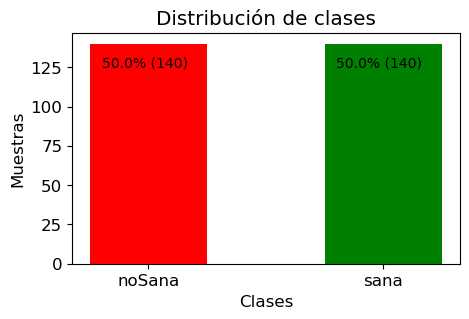

In [5]:
font = {'size'   : 12}
plt.rc('font', **font)

clases = list(etiquetas)
valores = list([dircount[0], dircount[1]])
fig = plt.figure(figsize = (5, 3))
 
plt.bar(clases, valores, color =["red", "green"], width = 0.5)
plt.xlabel("Clases")
plt.ylabel("Muestras")
plt.title("Distribución de clases")
plt.text(-0.2, dircount[0]-15,str(round(dircount[0]/(dircount[0]+dircount[1])*100,2)) + "% (" + str(dircount[0]) + ")", fontsize=10)
plt.text(0.8, dircount[1]-15, str(round(dircount[1]/(dircount[0]+dircount[1])*100,2)) + "% (" + str(dircount[1]) + ")", fontsize=10)
plt.show()

## 6. Se crean los sets de Entrenamiento y Test, Validación y Preprocesar

In [6]:
#Crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Cambia las etiquetas desde categorical a one-hot
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Muestra las etiquetas cambiadas desde category a one-hot
print('Etiqueta original:', train_Y[0])
print('Convertida a one-hot:', train_Y_one_hot[0])

train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (224, 128, 128, 3) (224,)
Testing data shape :  (56, 128, 128, 3) (56,)
Etiqueta original: 1
Convertida a one-hot: [0. 1.]
(179, 128, 128, 3) (45, 128, 128, 3) (179, 2) (45, 2)


In [7]:
np.save("test_X_aumentadas", test_X)
np.save("test_Y_aumentadas", test_Y)

In [8]:
test_X_combinado = np.load("test_X_aumentadas.npy")

## 7. Se crea la red

In [9]:
# Calculo de métrica F1
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = Sequential()

# Modelo
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=inputShape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nClasses, activation='softmax'))

model.summary()

#Funciones de pérdida
perd = "categorical_crossentropy"

#Optimizadores
opt = keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / epochs)

model.compile(loss=perd, optimizer=opt,metrics=['accuracy', f1_metric])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 21, 21, 64)        0

## 8. Se entrena la red

In [10]:
history = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

# Se guarda el modelo
model.save("modelo_aumentadas.h5")

Epoch 1/30
12/12 [==============================] - 2s 150ms/step - loss: 0.7848 - accuracy: 0.5084 - f1_metric: 0.5191 - val_loss: 0.6825 - val_accuracy: 0.4889 - val_f1_metric: 0.4872
Epoch 2/30
12/12 [==============================] - 2s 135ms/step - loss: 0.6714 - accuracy: 0.6201 - f1_metric: 0.6007 - val_loss: 0.6769 - val_accuracy: 0.6000 - val_f1_metric: 0.6010
Epoch 3/30
12/12 [==============================] - 2s 135ms/step - loss: 0.6623 - accuracy: 0.5754 - f1_metric: 0.5590 - val_loss: 0.6631 - val_accuracy: 0.7111 - val_f1_metric: 0.7196
Epoch 4/30
12/12 [==============================] - 2s 135ms/step - loss: 0.6163 - accuracy: 0.6927 - f1_metric: 0.7135 - val_loss: 0.6055 - val_accuracy: 0.7778 - val_f1_metric: 0.7772
Epoch 5/30
12/12 [==============================] - 2s 134ms/step - loss: 0.5952 - accuracy: 0.7207 - f1_metric: 0.7396 - val_loss: 0.5747 - val_accuracy: 0.7556 - val_f1_metric: 0.7564
Epoch 6/30
12/12 [==============================] - 2s 136ms/step - lo

## 9. Análisis de métricas de rendimiento

In [11]:
y_pred = model.predict(test_X)
y_pred.shape
test_Y.shape
y_pred[0,:].sum()

2/2 [==============================] - 0s 34ms/step


0.99999994

## 10. Resultados obtenidos

In [12]:
test_eval = model.evaluate(test_X, test_Y_one_hot, verbose=1)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
print('Test F1:', test_eval[2])

2/2 [==============================] - 0s 31ms/step - loss: 0.1494 - accuracy: 0.9286 - f1_metric: 0.9375
Test loss: 0.14943702518939972
Test accuracy: 0.9285714030265808
Test F1: 0.9375


## 11. Gráficos

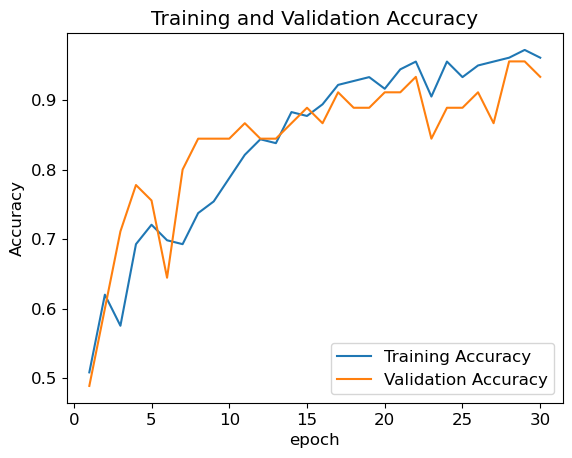

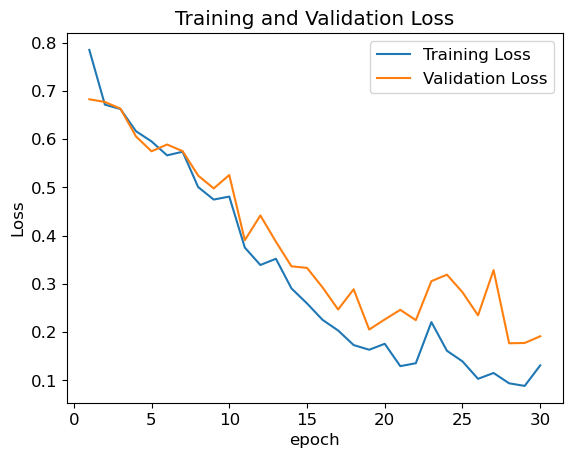

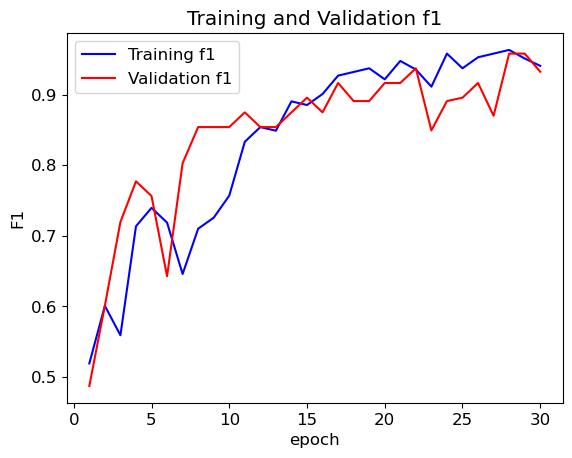

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history['f1_metric']
val_f1 = history.history['val_f1_metric']

epochs = range(1, len(acc) + 1)

# Accuracy de los datos de entrenamiento y datos de prueba
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.show()

# Pérdida de datos de entrenamiento y datos de prueba
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

# F1 de los datos de entrenamiento y datos de prueba
plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and Validation f1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("F1")
plt.show()

## 12. Matriz de confusión

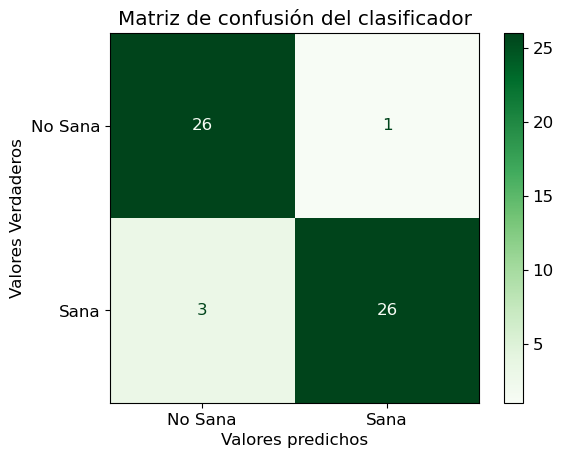

,No Sana,Sana,accuracy,macro avg,weighted avg
precision,0.896552,0.962963,0.928571,0.929757,0.930943
recall,0.962963,0.896552,0.928571,0.929757,0.928571
f1-score,0.928571,0.928571,0.928571,0.928571,0.928571
support,27.000000,29.000000,0.928571,56.000000,56.000000


In [18]:
def show_metrics(y_pred,th):
    cm = confusion_matrix(test_Y, y_pred.argmax(axis=1)>th)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Sana", "Sana"])
    disp.plot(cmap=plt.cm.Greens)
    plt.title('Matriz de confusión del clasificador')
    plt.xlabel('Valores predichos')
    plt.ylabel('Valores Verdaderos')
    plt.show()
    d = classification_report(test_Y, y_pred.argmax(axis=1) > th,output_dict=True, target_names=['No Sana', 'Sana'])
    display(pd.DataFrame.from_dict(d))
    return y_pred, d

a, mi_dicc = show_metrics(y_pred,.5)

In [15]:
#print(pd.DataFrame(mi_dicc).to_latex(index=False))

## 13. Puesta a prueba del modelo

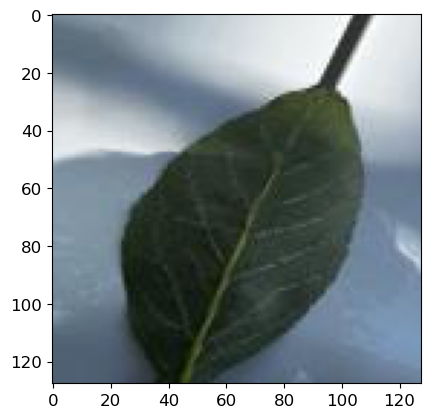

1/1 [==============================] - 0s 24ms/step
['noSana', 'sana']
[[0. 1.]]
Sana


In [16]:
from tensorflow.keras.preprocessing import image

#6 Hojas SANAS
img=image.load_img("FotosCombinadas/Sana/augmented_35_3786006.jpeg",target_size=DEFAULT_IMAGE_SIZE)
#img=image.load_img("FotosAumentadas/sana/augmented_10_1786905.jpeg",target_size=DEFAULT_IMAGE_SIZE)
#img=image.load_img("FotosOriginales/Sana/IMG_7912.jpeg",target_size=DEFAULT_IMAGE_SIZE)


#6 Hojas NO SANAS
#img=image.load_img("FotosCombinadas/NoSana/augmented_0_3427922.jpeg",target_size=DEFAULT_IMAGE_SIZE)
#img=image.load_img("FotosAumentadas/NoSana/augmented_0_8857250.jpeg",target_size=DEFAULT_IMAGE_SIZE)
#img=image.load_img("FotosOriginales/NoSana/IMG_7917.jpeg",target_size=DEFAULT_IMAGE_SIZE)

plt.imshow(img)
plt.show()

x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
images=np.vstack([x])
pred=model.predict(images,batch_size=16)
print(etiquetas)
print(pred)
if pred[0][0]>0.5:
    category="No Sana"
elif pred[0][1]>0.5:
    category="Sana"
        
print(category)